In [1]:
from data_loading.animal_keypoints_dataset import AnimalKeypointsDataset
from utils.transforms import RandomRotation, RandomFlip, RandomRatioCrop
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from models.conv_pose_machines import ConvolutionalPoseMachines
from utils.losses import MSECELoss, HMapsMSELoss
from utils.set_random_seed import set_random_seed, SEED
import torch
import os
# %cd ../../
from pose_estimation.cats.train import train
from utils.model_saver import ModelSaver
# %cd ./pose_estimation/cats/

set_random_seed(SEED)

INIT_WEIGHT_PATH = '../../models/weights/ConvolutionalPoseMachines_4_stages/HMapsMSELoss/Adam_lr_1e-05_betas_(0o9_0o999)_eps_1e-08/ConvolutionalPoseMachines_E899_B5.pth'
ALPHA = 0.00001
IMAGE_SIZE = (368, 368)
EPOCHS = 900
TRAIN_BATCH_SIZE = 5
TEST_BATCH_SIZE = 5
LOG_STEP = 30
SAVE_MODEL_STEP = 90
START_EPOCH = 900

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

all_tform = transforms.Compose([
    RandomFlip(0.5, 0.5),
    RandomRatioCrop(0.1, 0.1, 0.9, 0.9),
    RandomRotation((-30, 30)),
])

img_tform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

data_train = AnimalKeypointsDataset(
    json_file_path='../../dataset/cats/train/keypoints_annotations.json',
    image_dir='../../dataset/cats/train/labeled/',
    transform={'all': all_tform,
               'image': img_tform,
               'keypoints': transforms.ToTensor()},
    heatmap=True)
data_train_loader = DataLoader(data_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0)

data_test = AnimalKeypointsDataset(
    json_file_path='../../dataset/cats/test/keypoints_annotations.json',
    image_dir='../../dataset/cats/test/labeled/',
    transform={'all': all_tform,
               'image': img_tform,
               'keypoints': transforms.ToTensor()},
    heatmap=True)
data_test_loader = DataLoader(data_test, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=0)

Global seed set to 27


Model's weights will be saved to: ../../models/weights/ConvolutionalPoseMachines/HMapsMSELoss/Adam_lr_1e-05_betas_(0o9_0o999)_eps_1e-08/
Train loss: 1.8321841273988997, Epoch: 0
Test loss: 1.9634372472763062, Epoch: 0


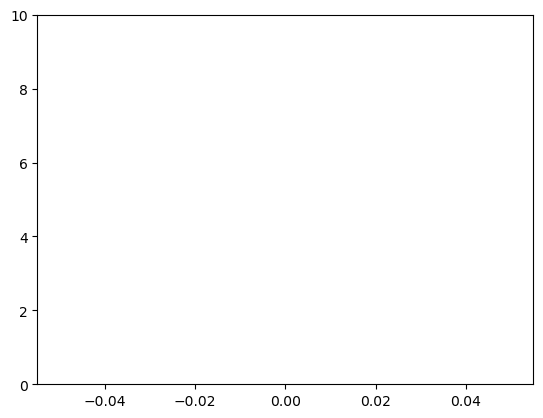

KeyboardInterrupt: 

In [2]:
model = ConvolutionalPoseMachines(
        n_keypoints=16,
        n_substages=3,
        n_base_ch=80,
        img_feat_ch=20
    )
model.to(device)
if os.path.isfile(INIT_WEIGHT_PATH):
    model.load_state_dict(torch.load(INIT_WEIGHT_PATH))
else:
    print("Weights not found.")
optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
loss = HMapsMSELoss().to(device)

model_saver = ModelSaver(model,
                         TRAIN_BATCH_SIZE,
                         save_freq=SAVE_MODEL_STEP,
                         start_epoch=START_EPOCH,
                         loss=loss,
                         optimizer=optimizer)

train(
    model=model,
    data_train=data_train_loader,
    data_test=data_test_loader,
    loss=loss,
    optimizer=optimizer,
    epochs=EPOCHS,
    model_saver=model_saver,
    logging_step=LOG_STEP,
    device=device
)